In [1]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from datasets import Audio, DatasetDict, load_dataset

from dasr.train.pl_model import DASRModel
from dasr.train.pl_tune_w2v import ASRModel
from dasr.train.pl_data import DASRDataModule
from dasr.datasets import RandomNoiseSNR
from dasr.datasets.make_dataloaders import CollateWithPadd

import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

In [3]:
import pandas as pd
import math
import re
from torchmetrics.text import CharErrorRate, WordErrorRate

def normalize_text(text: str):
    if isinstance(text, float) and math.isnan(text): # if an input text is empty, then we return an empty text too
        return ''
    
    for char in [".", ",", "!", "?", "(", ")"]:
        text = text.replace(char, " ")
    text = text.replace("ё", "е")
    text = re.sub(" +", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    return text

def normalize_df(df, column_names = ["transcription", "gt"]):
    for colname in column_names:
        df[colname] = df[colname].apply(normalize_text) 
        
    return df

def calculate_error_rates(target, preds):
    wer = WordErrorRate()
    cer = CharErrorRate()
    
    return wer(target=target, preds=preds).item(), cer(target=target, preds=preds).item()

def benchmark(model, dataset, collate_fn, lightning_val=False):
    
    loader = DataLoader(
                dataset,
                batch_size=16,
                collate_fn=collate_fn,
                shuffle=False,
                num_workers=5,
            )
        
    trainer = pl.Trainer(
        accelerator="cuda",
    )


    if lightning_val:
        # валидация самим лайтингом, нужно, чтобы узнать метрики модели без денойзера
        print(trainer.validate(model, loader))
        return None, None, None

    else:
        outputs = trainer.predict(model, loader)
        
        transcripts = []
        for i in outputs:
            asr_output = i[0]
            pred_ids = torch.argmax(asr_output.logits, dim=-1)
            denoisy_transcript = model.asr.processor.batch_decode(pred_ids)
            transcripts.extend(denoisy_transcript)
            
        gts = dataset.transcriptions
        
        df = pd.DataFrame({"transcription": transcripts, "gt": gts})
        
        df = normalize_df(df)
        wer, cer = calculate_error_rates(df["gt"], df["transcription"])
        return wer, cer, df
    

In [4]:
collate_fn = CollateWithPadd().collate_fn

# Грузим Датасет

In [5]:
def fill_na(x):
    if x["sentence"] is None:
        x["sentence"] = ""
    # x["audio"]["array"] = x["audio"]["array"] * 4  
    return x

def get_ru_dataset(name, split="test[0:5000]", sampling_rate=16000):
    if name == "golos_farfield":
        hf_name = "bond005/sberdevices_golos_100h_farfield"
    elif name == "golos_crowd":
        hf_name = "bond005/sberdevices_golos_10h_crowd"
    elif name == "sova":
        hf_name = "bond005/sova_rudevices"
    elif name == "fleurs":
        hf_name = "google/fleurs"
    else:
        raise ValueError("Нет такого датасета")
        
    if name in [ "golos_farfield", "golos_crowd", "sova"]:
        dataset = load_dataset(hf_name, split=split)
        dataset = dataset.rename_column("transcription", "sentence")
        dataset = dataset.map(fill_na)

        dataset = dataset.cast_column(
            "audio", Audio(sampling_rate=sampling_rate)
            )
    elif name == "fleurs": 
        dataset = load_dataset(hf_name, "ru_ru", split=split)
        dataset = dataset.rename_column("transcription", "sentence")
        dataset = dataset.map(fill_na)
        dataset = dataset.cast_column(
            "audio", Audio(sampling_rate=sampling_rate)
            )
        
    return dataset


def get_en_dataset(name, split="test[0:5000]", sampling_rate=16000):

    if name == "fleurs":
        hf_name = "google/fleurs"
    elif name == "librispeech_other":
        hf_name = "openslr/librispeech_asr"
        part = "other"
    elif name == "librispeech_clean":
        hf_name = "openslr/librispeech_asr"
        part = "clean"
    else:
        raise ValueError("Нет такого датасета")
        
    if name == "fleurs": 
        dataset = load_dataset(hf_name, "en_us", split=split)
        dataset = dataset.rename_column("transcription", "sentence")
        dataset = dataset.map(fill_na)
        dataset = dataset.cast_column(
            "audio", Audio(sampling_rate=sampling_rate)
            )
    elif name in ["librispeech_other", "librispeech_clean"]:
        dataset = load_dataset(hf_name, part, "en", split=split)
        dataset = dataset.rename_column("text", "sentence")
        dataset = dataset.map(fill_na)
        dataset = dataset.cast_column(
            "audio", Audio(sampling_rate=sampling_rate)
            )
        
    return dataset

In [6]:
hf_dataset = get_en_dataset("librispeech_other")
dataset = RandomNoiseSNR(hf_dataset, desire_snr_range_db=[10, 10])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for openslr/librispeech_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/openslr/librispeech_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/2939 [00:00<?, ? examples/s]

In [7]:
# hf_dataset = get_ru_dataset("fleurs")
# dataset = RandomNoiseSNR(hf_dataset, desire_snr_range_db=[10, 10])

# Грузим модель и бенчмаркаем

In [8]:
def ger_ru_models(language):
    if language == "ru":
        best_denoiser_path = "./../../checkpoints/[only ctc] wav2vec+pretrained_dns64 [lr=1e-4] (unfreeze), SNR=10, train[0:20000]/epoch=22.ckpt"
        best_finetune_path = "./../../checkpoints/[tune w2v] [lr=1e-4] SNR=10, train[0:20000]/epoch=13.ckpt"
    elif language == "en":
        best_denoiser_path = "/home/docker_current/dasr/checkpoints/EN [ctc] wav2vec2+pretrained_dns64 [lr=1e-4] (unfreeze), SNR in [10, 10], train[0:20000]/epoch=31.ckpt"
        best_finetune_path = "/home/docker_current/dasr/checkpoints/EN [tune w2v] [lr=0.5e-4] SNR=10, train[0:20000] second run/epoch=20.ckpt"
    else:
        raise ValueError("Нет такого языка")
    
    denoiser_model = DASRModel.load_from_checkpoint(best_denoiser_path, map_location="cpu")
    finetune_model = ASRModel.load_from_checkpoint(best_finetune_path, map_location="cpu")
    return denoiser_model, finetune_model

In [9]:
denoiser_model, finetune_model = ger_ru_models(language="en")
# denoiser_model, finetune_model = ger_ru_models(language="ru")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [10]:
# Метрики для денойзинга
wer, cer, df = benchmark(denoiser_model, dataset, collate_fn)
wer * 100, cer * 100

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100 80

Predicting: |          | 0/? [00:00<?, ?it/s]

(23.504576086997986, 9.981292486190796)

In [11]:
# Метрики для файнтюна
wer, cer, df = benchmark(finetune_model, dataset, collate_fn)
wer * 100, cer * 100

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2, 3]


Predicting: |          | 0/? [00:00<?, ?it/s]

(25.134211778640747, 10.560902953147888)

In [12]:
# Метрики оригинальной модели распознавания
benchmark(denoiser_model, dataset, collate_fn, lightning_val=True)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2, 3]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val/asr_loss        │    0.5226469039916992     │
│   val/cer (gt-denoisy)    │    0.10281646251678467    │
│    val/cer (gt-noisy)     │    0.13210876286029816    │
│     val/cer (gt-ref)      │    0.04542924836277962    │
│          val/l1           │    0.20548531413078308    │
│       val/mag_loss        │    0.05556846037507057    │
│        val/sc_loss        │    0.1116330549120903     │
│      val/total_loss       │    0.3726867139339447     │
│   val/wer (gt-denoisy)    │    0.2453964501619339     │
│    val/wer (gt-noisy)     │     0.294201523065567     │
│     val/wer (gt-ref)      │    0.13522295653820038    │
└───────────────────────────┴───────────────────────────┘

[{'val/l1': 0.20548531413078308, 'val/sc_loss': 0.1116330549120903, 'val/mag_loss': 0.05556846037507057, 'val/total_loss': 0.3726867139339447, 'val/asr_loss': 0.5226469039916992, 'val/wer (gt-ref)': 0.13522295653820038, 'val/cer (gt-ref)': 0.04542924836277962, 'val/wer (gt-denoisy)': 0.2453964501619339, 'val/cer (gt-denoisy)': 0.10281646251678467, 'val/wer (gt-noisy)': 0.294201523065567, 'val/cer (gt-noisy)': 0.13210876286029816}]


(None, None, None)

In [15]:
clean_signal, noise_signal =  dataset[0]["clean_audio"], dataset[0]["noise_audio"]

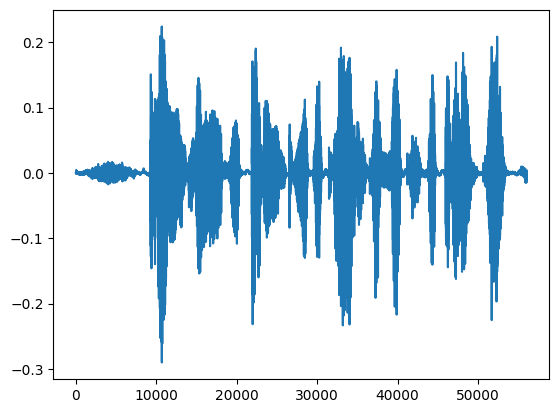

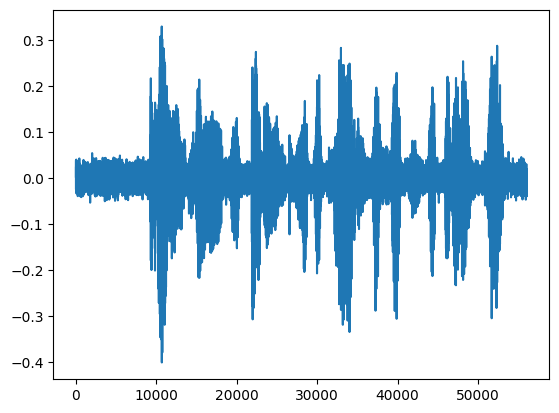

In [16]:
plt.figure()
# plt.plot(denoisy[0:n_nonmask_elem])
plt.plot(clean_signal)
plt.figure()
plt.plot(noise_signal)

# Trash

In [15]:
# split = "test"

# tmp = load_dataset("openslr/librispeech_asr", "clean", "en", split=split)

Generating train.100 split:   0%|          | 0/28539 [00:00<?, ? examples/s]

Generating train.360 split:   0%|          | 0/104014 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2703 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2620 [00:00<?, ? examples/s]

In [17]:
tmp[0]

{'file': '/home/docker_current/.cache/huggingface/datasets/downloads/extracted/8545cdda50835f4e7a1508d1f0a4aa35a20165faa0288a5e74cb425f73dfa0c0/6930-75918-0000.flac',
 'audio': {'path': '/home/docker_current/.cache/huggingface/datasets/downloads/extracted/8545cdda50835f4e7a1508d1f0a4aa35a20165faa0288a5e74cb425f73dfa0c0/6930-75918-0000.flac',
  'array': array([-6.10351562e-05,  9.15527344e-05,  1.06811523e-03, ...,
         -2.19726562e-03, -1.13830566e-02, -8.81958008e-03]),
  'sampling_rate': 16000},
 'text': 'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS',
 'speaker_id': 6930,
 'chapter_id': 75918,
 'id': '6930-75918-0000'}

In [ ]:
# Лучший размороженный RU денойзер
# path = "./../../checkpoints/[only ctc] wav2vec+pretrained_dns64 [lr=1e-4] (unfreeze), SNR=10, train[0:20000]/epoch=22.ckpt"
# Лучший денойзер с замороженным энкодером
# path = "/home/docker_current/dasr/checkpoints/[only ctc] wav2vec+pretrained_dns64 [lr=1e-4] (freeze encoder), SNR=10, train[0:20000] second run/epoch=64.ckpt"

# model = DASRModel.load_from_checkpoint(path, map_location="cpu")

# Затюненная модель
# finetune_path = "./../../checkpoints/[tune w2v] [lr=1e-4] SNR=10, train[0:20000]/epoch=13.ckpt"
# model = ASRModel.load_from_checkpoint(finetune_path, map_location="cpu")

In [ ]:
# # name="bond005/sberdevices_golos_100h_farfield"
# name = "bond005/sberdevices_golos_10h_crowd"

# # name = "bond005/sova_rudevices"
# split="test[0:5000]"

# sampling_rate=16000

# sbergolos = DatasetDict()
# sbergolos = load_dataset(name, split=split)
# sbergolos = sbergolos.rename_column("transcription", "sentence")
# sbergolos = sbergolos.map(fill_na)

# sbergolos = sbergolos.cast_column(
#     "audio", Audio(sampling_rate=sampling_rate)
# )

In [216]:
batch = next(iter(loader))

In [217]:
_, denoisy_speech = model(batch)

In [225]:
from IPython.display import Audio as iAudio
from IPython.display import display

ind = 3

denoisy = denoisy_speech[ind].detach().numpy()
noisy = batch["noise_audios"][ind].numpy()
clear = batch["clean_audios"][ind].numpy()
attention_mask = batch["noise_attention_masks"][ind].numpy()

n_nonmask_elem = int(attention_mask.sum()) - 600

display(iAudio(clear, rate=16000))
display(iAudio(noisy[0:n_nonmask_elem], rate=16000))
display(iAudio(denoisy[0:n_nonmask_elem], rate=16000))

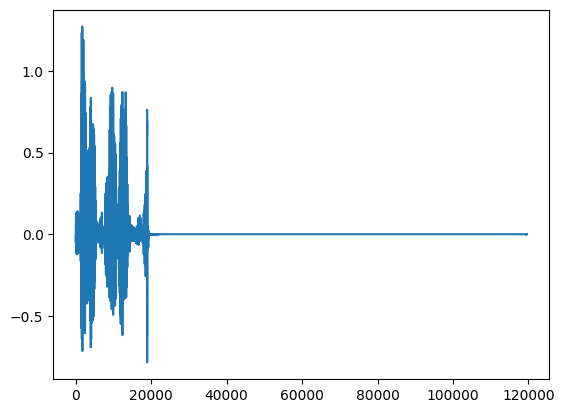

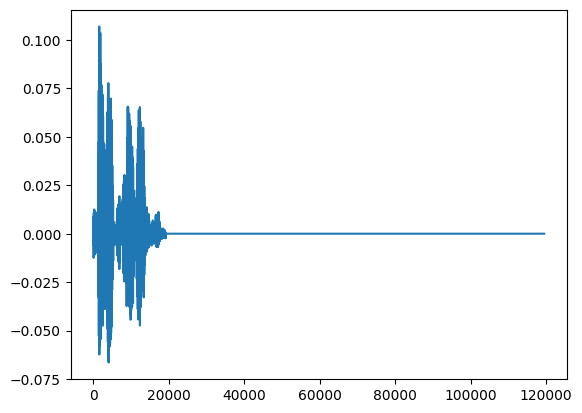

In [223]:
plt.figure()
# plt.plot(denoisy[0:n_nonmask_elem])
plt.plot(denoisy)
plt.figure()
plt.plot(clear)

# Проверка всяких штук на CommonVoice

In [142]:
name="mozilla-foundation/common_voice_11_0"
language="ru"
split="test"
sampling_rate=16000
removavle_cols=[
    "accent",
    "age",
    "client_id",
    "down_votes",
    "gender",
    "locale",
    "path",
    "segment",
    "up_votes",
]

common_voice = load_dataset(name, language, split=split)
common_voice = common_voice.remove_columns(removavle_cols)
common_voice = common_voice.cast_column(
    "audio", Audio(sampling_rate=sampling_rate)
)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [102]:
maxes = [max(i["audio"]["array"]) for i in common_voice]
sum(maxes) / len(maxes)

0.608234144906203

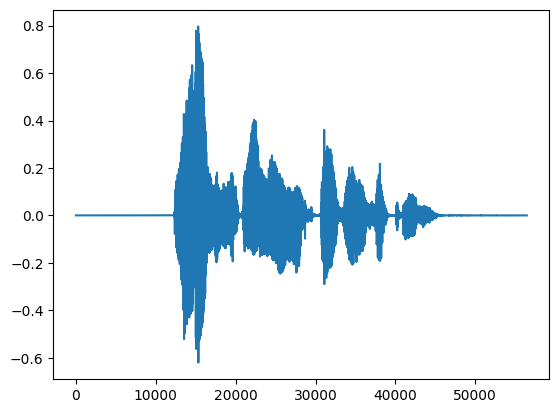

In [99]:
sample =  common_voice[2]["audio"]["array"]
plt.plot(sample)

In [143]:
commonvoice_dataset = RandomNoiseSNR(common_voice, desire_snr_range_db=[10, 10])

In [144]:
collate_fn = CollateWithPadd().collate_fn

commomvoice_loader = DataLoader(
            commonvoice_dataset,
            batch_size=24,
            collate_fn=collate_fn,
            shuffle=False,
            num_workers=5,
        )

In [145]:
trainer = pl.Trainer(
    accelerator="cuda",
    devices=[0],
)

trainer.validate(model, commomvoice_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val/asr_loss        │    0.4089887738227844     │
│   val/cer (gt-denoisy)    │    0.09748871624469757    │
│    val/cer (gt-noisy)     │    0.1321870982646942     │
│     val/cer (gt-ref)      │    0.04918943718075752    │
│   val/wer (gt-denoisy)    │    0.3137265741825104     │
│    val/wer (gt-noisy)     │    0.3897615373134613     │
│     val/wer (gt-ref)      │    0.19054648280143738    │
└───────────────────────────┴───────────────────────────┘

[{'val/asr_loss': 0.4089887738227844,
  'val/wer (gt-ref)': 0.19054648280143738,
  'val/cer (gt-ref)': 0.04918943718075752,
  'val/wer (gt-denoisy)': 0.3137265741825104,
  'val/cer (gt-denoisy)': 0.09748871624469757,
  'val/wer (gt-noisy)': 0.3897615373134613,
  'val/cer (gt-noisy)': 0.1321870982646942}]